In [ ]:
pip install torch transformers datasets ndlinear


In [1]:
import torch
import torch.nn as nn
from transformers import DistilBertTokenizerFast, DistilBertModel
from datasets import load_dataset
from ndlinear import NdLinear
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# dataset: https://huggingface.co/datasets/ag_news
dataset = load_dataset("ag_news")
dataset["train"].shuffle(seed=42).select(range(5))


In [8]:
dataset["train"].features["label"].int2str(3)  # returns 'Sci/Tech'


'Sci/Tech'

In [9]:
label_names = dataset["train"].features["label"].names
print(label_names)


['World', 'Sports', 'Business', 'Sci/Tech']


In [11]:
train_data = dataset["train"].shuffle(seed=42).select(range(10000))
test_data = dataset["test"].select(range(2000))

In [ ]:
# TOKENIZATION
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

In [ ]:
train_data = train_data.map(tokenize, batched=True)
test_data = test_data.map(tokenize, batched=True)

In [14]:
# FORMAT FOR TORCH
columns = ["input_ids", "attention_mask", "label"]
train_data.set_format(type="torch", columns=columns)
test_data.set_format(type="torch", columns=columns)

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(tokenized_example["input_ids"][0])
print(tokens[:20])  # Preview first 20 tokens



In [19]:
# DATALOADER
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

In [ ]:
# MODEL DEFINITION
class NdLinearTextClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.ndlinear = NdLinear(input_dims=(128, 768), hidden_size=(128, 256))  # sequence × embedding
        self.pool = nn.AdaptiveAvgPool1d(1)  # pool along tokens
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():  # freeze BERT weights to save memory
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden = bert_output.last_hidden_state  # (batch, seq_len, hidden_size)
        x = self.ndlinear(hidden)  # (batch, 128, 256)
        x = x.permute(0, 2, 1)  # (batch, 256, 128) for pooling
        pooled = self.pool(x).squeeze(-1)  # (batch, 256)
        return self.classifier(pooled)

model = NdLinearTextClassifier().to(device)

In [21]:
# TRAINING SETUP
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
epochs = 3

In [22]:
# TRAINING
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

Epoch 1, Loss: 0.4716
Epoch 2, Loss: 0.3112
Epoch 3, Loss: 0.2956


In [23]:
# EVALUATION
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {acc:.4f}")


Test Accuracy: 0.9035


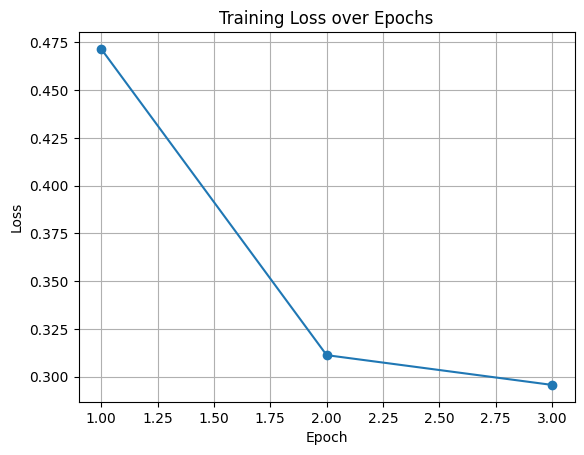

In [24]:
#EPOCH LOSS GRAPH
import matplotlib.pyplot as plt

epochs = [1, 2, 3]
train_loss = [0.4716, 0.3112, 0.2956]
plt.plot(epochs, train_loss, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()


In [25]:
#TOTAL PARAMETERS USED WITH NDLINEAR
param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable Parameters with NdLinear: {param_count:,}")

Trainable Parameters with NdLinear: 66,577,284


In [30]:
#USE THE MODEL
model.eval()
text = "Oscar Piastri wins the F1 Driver's championship"
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)

with torch.no_grad():
    output = model(input_ids, attention_mask)
    prediction = torch.argmax(output, dim=1).item()
label_names = ["World", "Sports", "Business", "Sci/Tech"]
print("Predicted Category:", label_names[prediction])


Predicted Category: Sports


In [31]:
#SAVE THE MODEL
torch.save(model.state_dict(), "ndlinear_news_classifier.pth")   #this only saves the weight

In [32]:
#SAVE THE FILE LOCALLY
from google.colab import files
files.download("ndlinear_news_classifier.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>